In [1]:
import tensorflow as tf
tf.enable_eager_execution()
import numpy as np
import matplotlib.pyplot as plt
import math, cv2, glob, time, xlrd, os
import imageio as io
from load_data import load_data
from utils import *

Using TensorFlow backend.


In [2]:
p      = './exposure_value/exposure_value_part1.xls'
wb     = xlrd.open_workbook(p)
sheet1 = wb.sheet_by_index(0)

In [3]:
ch = 6
w  = 2736
h  = 1824
results_path   = './result_final_test/'
if not os.path.exists(results_path):
  os.makedirs(results_path)

In [6]:
def test(model, path): 
  
  model.load_weights(path)
  psnr = []
  ssim = []

  data_dir   = './Dataset/test/'
  scene_dirs = [scene_dir for scene_dir in os.listdir(data_dir) if scene_dir!="Label"]
  scene_dirs = sorted(scene_dirs, key=lambda i: int(os.path.splitext(os.path.basename(i))[0]))
  num_scenes = len(scene_dirs)
  
  t_total = 0.0
  for index in range(num_scenes):
    cur_path = scene_dirs[index]
    if cur_path=="Label":
      continue
    cur_path = os.path.join(data_dir, cur_path)
  
    no          = int(scene_dirs[index])
    under_index = int(sheet1.cell_value(no, 1))
    over_index  = int(sheet1.cell_value(no, 2))
        
    over_exp  = cv2.imread(os.path.join(cur_path, str(over_index) + '.JPG'))
    over_exp  = over_exp[:, :, ::-1]
    under_exp = cv2.imread(os.path.join(cur_path, str(under_index) + '.JPG'))
    under_exp = under_exp[:, :, ::-1]
        
    ''' finding corresponding ldr image ''' 
    label_p = os.path.join(data_dir, 'Label', str(no) + '.JPG')    
    label   = cv2.imread(label_p)
    label   = label[:, :, ::-1]
    
    over_exp  = cv2.resize(over_exp, (w, h))
    under_exp = cv2.resize(under_exp, (w, h))
    label     = cv2.resize(label, (w, h))   
    
    ''' bring to [0,1] '''
    over_exp  = norm_0_to_1(over_exp)
    under_exp = norm_0_to_1(under_exp)
    label     = norm_0_to_1(label) 
    
    img = np.concatenate([under_exp, over_exp], axis=2)
    img = np.expand_dims(img, axis=0)          
    
    img = img*2.0-1.0
    t_start = time.time()
    ldr     = model.predict(img)
    t_total = t_total + time.time() - t_start
    ldr     = np.squeeze(ldr)
    ldr_    = ((ldr+1.)/2.)
    
    tem = ldr_*255.
    tem = tem.astype(np.uint8)
    plt.imshow(tem)
    plt.show()
    
    psnr_result = tf.image.psnr(ldr_, label, max_val=1.0)
    ssim2       = tf.image.ssim(tf.squeeze(ldr_), tf.squeeze(label), max_val=1.0)
    print('no%d, psnr_result:%f, ssim:%f'%(no, psnr_result, ssim2))
    #io.imwrite(results_path + str(no) + '.png', tem)
    ssim.append(ssim2)
    psnr.append(psnr_result)
    
  print('total_time:', t_total)
  print('average_psnr:', np.mean(psnr))
  print('average_ssim:', np.mean(ssim))


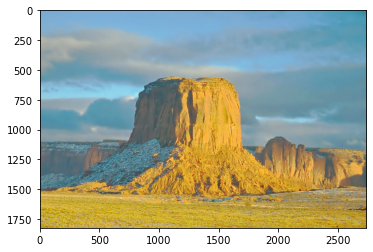

no3, psnr_result:19.552856, ssim:0.817354


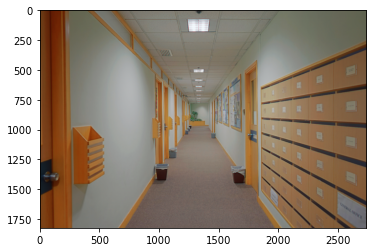

no13, psnr_result:22.715862, ssim:0.898511


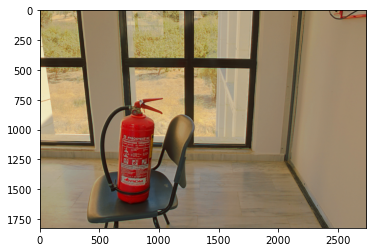

no33, psnr_result:23.900576, ssim:0.844788


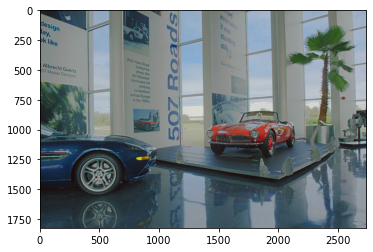

no250, psnr_result:19.036551, ssim:0.789900


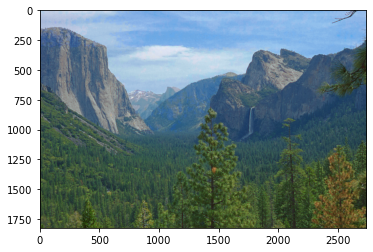

no272, psnr_result:24.531454, ssim:0.775170
total_time: 1.8133020401000977
average_psnr: 21.94746
average_ssim: 0.82514465


In [7]:
path  = 'addtion_merge.h5'
model = supervised_model(h, w , ch)
test(model, path)